# CS Recon using TV-Minimization

In [1]:
try:
    import nibabel as nib
except:
    !pip install nibabel
    import nibabel as nib
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import torch
import tensorflow as tf
import torch.fft as fft

#considered saggital view for square dimension data
#for validation and evaluation
def data_load(image):
  img1_data = image.get_data()
  img_data_arr = np.asarray(img1_data)
  X=(np.uint8(np.ceil(img_data_arr.shape[1]/2)))
  #print(X)
  img_val=img_data_arr[:,:,X-5:X+5]
  return img_val

def row_Mask_test(image,c_level):
  import random
  import math
  [row,col]=image.shape
  if row%2 ==0 :
    r = np.uint8(row/2)
  else :
    r = np.uint8((row+1)/2)
  img_mask_np=np.ones([row,col])
  n = row - row/c_level
  N=random.sample(range(1, row), math.ceil(n))
  for j in N:
    if j in range(r-15,r+15):
      continue
    img_mask_np[j,:]=np.zeros([1,col])
  return img_mask_np

### Load .nii file

<ipython-input-60-5c6ef858863e>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img_data = img1.get_data()


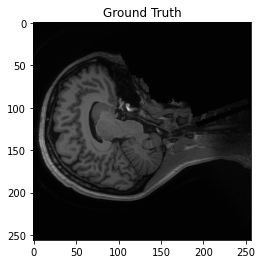

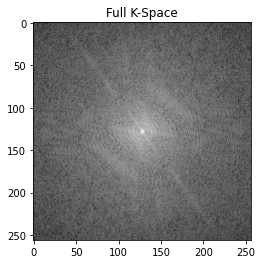

In [60]:
img1 = nib.load('/home/ubuntu/Downloads/dataset/singlecoil_val.nii')
img_data = img1.get_data()
img_data_arr = np.asarray(img_data)
test_1=img_data_arr[:,:,88+9]
plt.imshow(test_1,cmap='gray')
plt.title('Ground Truth')
plt.figure()
data = test_1.astype(np.float32)
img_torch = torch.from_numpy(data)
fft_img_torch = torch.fft.fft2(img_torch,norm="ortho")
fft_img_torch = torch.fft.fftshift(fft_img_torch) 
plt.imshow(20*np.log(torch.abs(fft_img_torch)),cmap='gray')
plt.title('Full K-Space')
img_data_arr = img_data_arr.astype(np.float32)
img_data_torch = torch.from_numpy(img_data_arr)

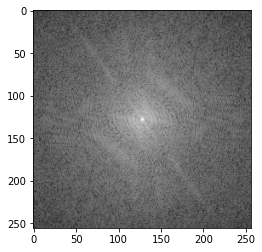

In [62]:
data = test_1.astype(np.float32)
img_torch = torch.from_numpy(data)
fft_img_torch = torch.fft.fft2(img_torch,norm="ortho")
fft_img_torch = torch.fft.fftshift(fft_img_torch) 
plt.imshow(20*np.log(torch.abs(fft_img_torch)),cmap='gray')

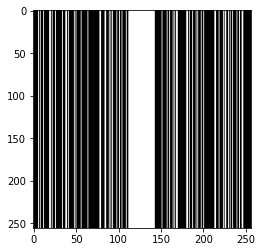

In [63]:
Mask_1=row_Mask_test(img_torch,4)
Mask_1 = Mask_1.T
mask_tensor=torch.from_numpy(Mask_1.astype(np.float32))
plt.imshow(Mask_1,cmap='gray')


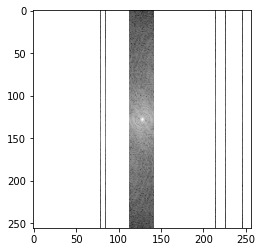

In [64]:
compressed_img_fft=torch.multiply(mask_tensor,fft_img_torch)
plt.imshow(20*torch.log(torch.abs(compressed_img_fft)),cmap='gray')

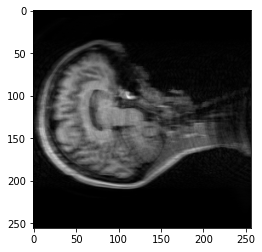

In [65]:
compressed_img = torch.fft.ifft2(torch.fft.ifftshift(compressed_img_fft))
plt.imshow((torch.abs(compressed_img)),cmap='gray')

### Evaluate k-space based tv minimization

In [66]:
import sys
sys.path.insert(0,'../../common/')
import bart

compressed_img_fft = compressed_img_fft.detach().cpu().numpy()
sens_maps = bart.bart(1, f'ecalib -d0 -m1', compressed_img_fft)
pred = bart.bart(1, f'pics -d0 -S -R T:7:0:{0.01} -i {1000}', compressed_img_fft, sens_maps)

In [67]:
from skimage.measure import compare_ssim
from skimage.metrics import peak_signal_noise_ratio
c = compressed_img.numpy()
(score, diff) = compare_ssim(np.abs(c), test_1, full=True)
psnr1 = peak_signal_noise_ratio(test_1,np.abs(c) ,data_range=test_1.max()-test_1.min())
print(score,psnr1)

0.3015727644151776 16.97141918990106


<ipython-input-67-40c13f1049aa>:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(np.abs(c), test_1, full=True)


Text(0.5, 1.0, 'Reconstructed Image')

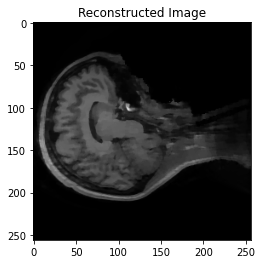

In [68]:
pred = np.fft.ifftshift(pred)
plt.imshow(np.abs(pred),cmap='gray')
plt.title('Reconstructed Image')

### Compute metrics

In [69]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.measure import compare_ssim

c = compressed_img.numpy()
im2 = np.abs(c)
im1 = np.copy(test_1)
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()
(score, diff) = compare_ssim(im2,im1, full=True)
psnr1 = peak_signal_noise_ratio(im1,im2,data_range=im1.max()-im1.min())
print(f'Compressed Sensed Image: SSIM = {score:.3f}, PSNR = {psnr1:.3f}')
im2 = np.copy(np.abs(pred))
im1 = test_1
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()
(score, diff) = compare_ssim(im1,im2,full=True)
psnr1 = peak_signal_noise_ratio(im1,im2,data_range=im2.max()-im2.min())
print(f'Reconstructed Image: SSIM = {score:.3f}, PSNR = {psnr1:.3f}')

Compressed Sensed Image: SSIM = 0.848, PSNR = 31.387
Reconstructed Image: SSIM = 0.483, PSNR = 34.358


<ipython-input-69-6cea18b79aed>:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(im2,im1, full=True)
<ipython-input-69-6cea18b79aed>:18: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(im1,im2,full=True)


### Visualise Outputs

(-0.5, 255.5, 255.5, -0.5)

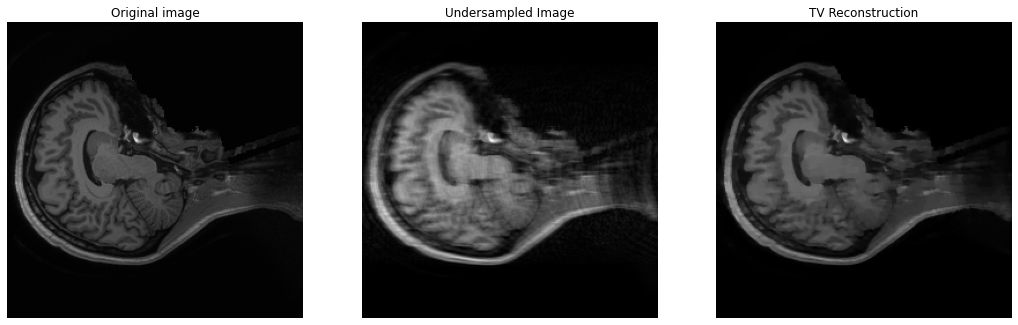

In [70]:
fig = plt.figure(figsize = (18,16)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(131)
ax1.imshow(test_1,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(torch.abs(compressed_img),cmap='gray')
ax2.set_title( "Undersampled Image") 
ax2.axis('off') 

ax3 = fig.add_subplot(133)
ax3.imshow(np.abs(pred),cmap='gray')
ax3.set_title( "TV Reconstruction" ) 
ax3.axis('off')